# **Dataset and Project Background**

## **What is pneumonia?**

"Pneumonia is an infection of one or both lungs that triggers inflammation and causes the air sacs (alveoli) of the lung to fill with pus or liquid. Symptoms include coughing, shortness of breath, and fever, and can be mild to life-threatening."
Harvard Health Publishing. (2024, June 24). Pneumonia: Symptoms, causes, and treatment. Harvard Health. https://www.health.harvard.edu/topics/pneumonia

## **Project Goal**


A deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

## **Dataset Overview**

Chest X-Ray Images (Pneumonia) – Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

- 5,863 total images across training, test, and validation folders
- Two classes: `NORMAL`, `PNEUMONIA`

# **Import**

In [ ]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121

# **Load Dataset + Resize + Grayscale Images**

## Check Image Size

In [ ]:
# Get a sample image path
sample_image_path = '/data/train/NORMAL/NORMAL2-IM-1423-0001.jpeg'

# Load and check size
img = cv.imread(sample_image_path)
print(f"Image shape: {img.shape}")

Image shape: (1216, 1400, 3)


The image is 1216x1400px and has 3 channels(RGB), it will be reshaped to (224, 224, 1) (grayscale), whereby it will be changed from RGB to grayscale because:


*   X-rays are naturally grayscale - color information is irrelevant as pneumonia patterns visible in grayscale
*   Reduces computation - 1 channel instead of 3


## Constants (Image size)

In [ ]:
IMG_SIZE = 224

## Load train, test, and validation Datasets + Resize + Grayscale

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/data/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    color_mode='grayscale'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/data/test',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    color_mode='grayscale'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/data/val',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    color_mode='grayscale'
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


# **Part 1: Data Exploration**

## Visualize sample X-ray images


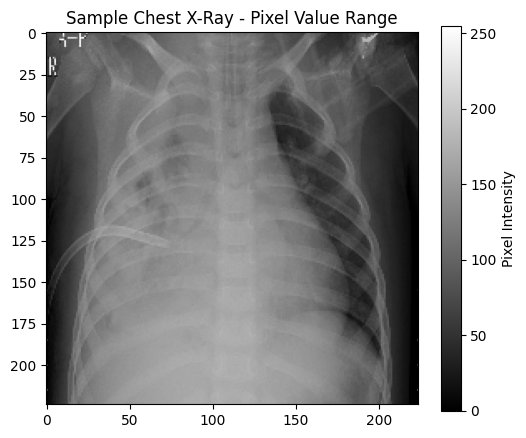

In [ ]:
# Visualize pixel range with colorbar
plt.figure(figsize=(6, 5))
for images, labels in train_dataset.take(1):
    sample_image = images[0].numpy().squeeze()
    plt.imshow(sample_image, cmap='gray')
    plt.colorbar(label='Pixel Intensity')
    plt.title('Sample Chest X-Ray - Pixel Value Range')
    plt.show()

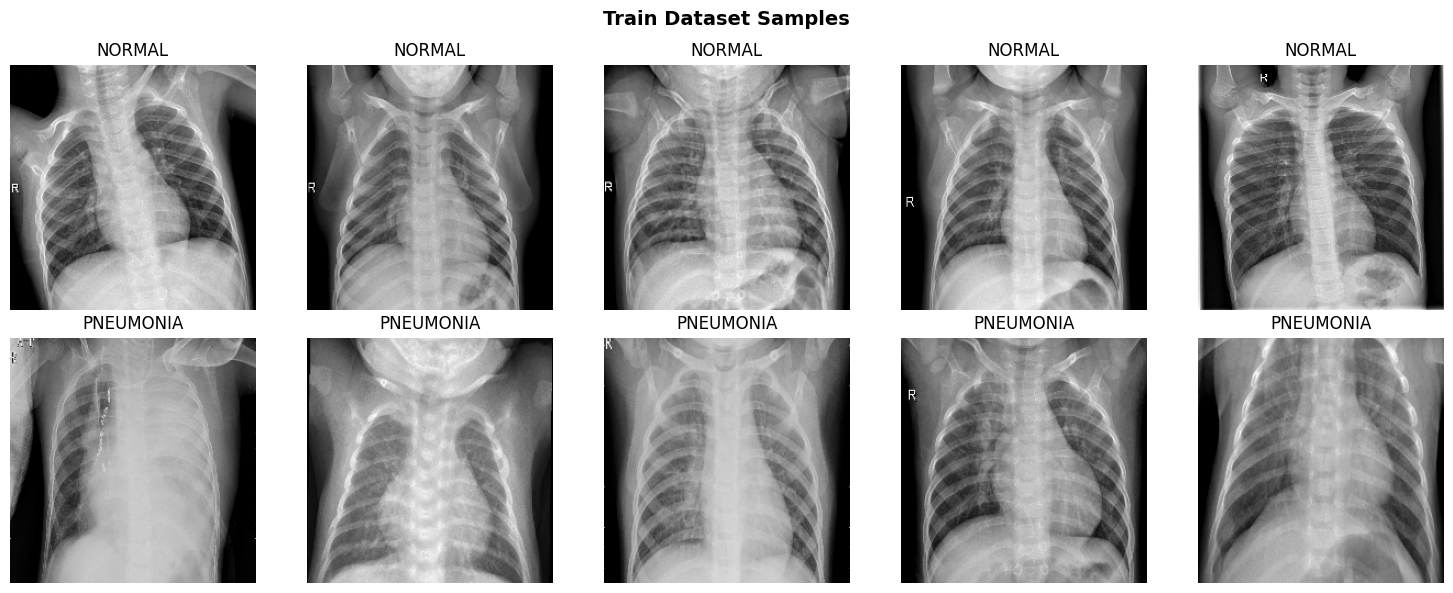

In [ ]:
# Visualize 10 samples: 5 Normal and 5 PNEUMONIA
def visualize_samples(dataset, title="Dataset Samples"):
    class_names = ['NORMAL', 'PNEUMONIA']

    plt.figure(figsize=(15, 6))

    for images, labels in dataset.take(1):
        # Separate by class
        normal_images = images[labels == 0][:5]
        pneumonia_images = images[labels == 1][:5]

        # Plot NORMAL class
        for i in range(5):
            plt.subplot(2, 5, i + 1)
            plt.imshow(normal_images[i].numpy().squeeze(), cmap='gray')
            plt.title('NORMAL')
            plt.axis('off')

        # Plot PNEUMONIA class
        for i in range(5):
            plt.subplot(2, 5, i + 6)
            plt.imshow(pneumonia_images[i].numpy().squeeze(), cmap='gray')
            plt.title('PNEUMONIA')
            plt.axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


visualize_samples(train_dataset, "Train Dataset Samples")

## Class distribution

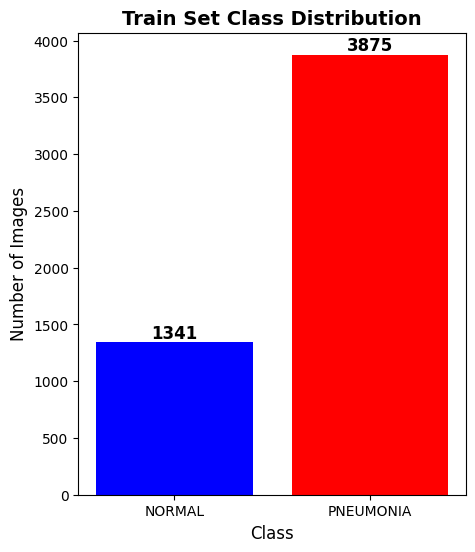

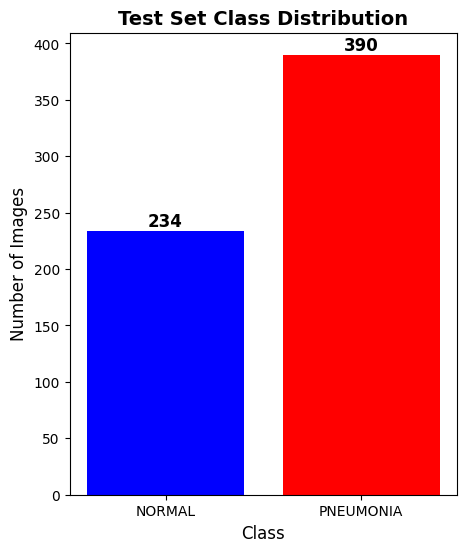

In [ ]:
# Function to plot class distribution
def plot_class_distribution(dataset, title):
    normal_count = 0
    pneumonia_count = 0

    for images, labels in dataset:
        normal_count += np.sum(labels == 0)
        pneumonia_count += np.sum(labels == 1)

    classes = ['NORMAL', 'PNEUMONIA']
    counts = [normal_count, pneumonia_count]

    plt.figure(figsize=(5, 6))
    bars = plt.bar(classes, counts, color=['blue', 'red'])

    # Add count labels on top of bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12)
    plt.xlabel('Class', fontsize=12)
    plt.show()

# Call function on both datasets
plot_class_distribution(train_dataset, 'Train Set Class Distribution')
plot_class_distribution(test_dataset, 'Test Set Class Distribution')

## Analysis

The data is imbalanced, the number of sampled for pneumonia are much more than that of normal(training: Normal(1341) < pneumonia (3875), testing: Normal(250) < Pneumonia (406)). Data augmentation will be performed to resolve the issue.


# **Part 2: Data Preprocessing**

## Resizing images was already done upon loading data.

## Normalize Pixels

In [ ]:
# Normalize train, test datasets
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

### Verify Data: To verify that the dataset looks correct: plot again some images from the training set and display the class name below each image.

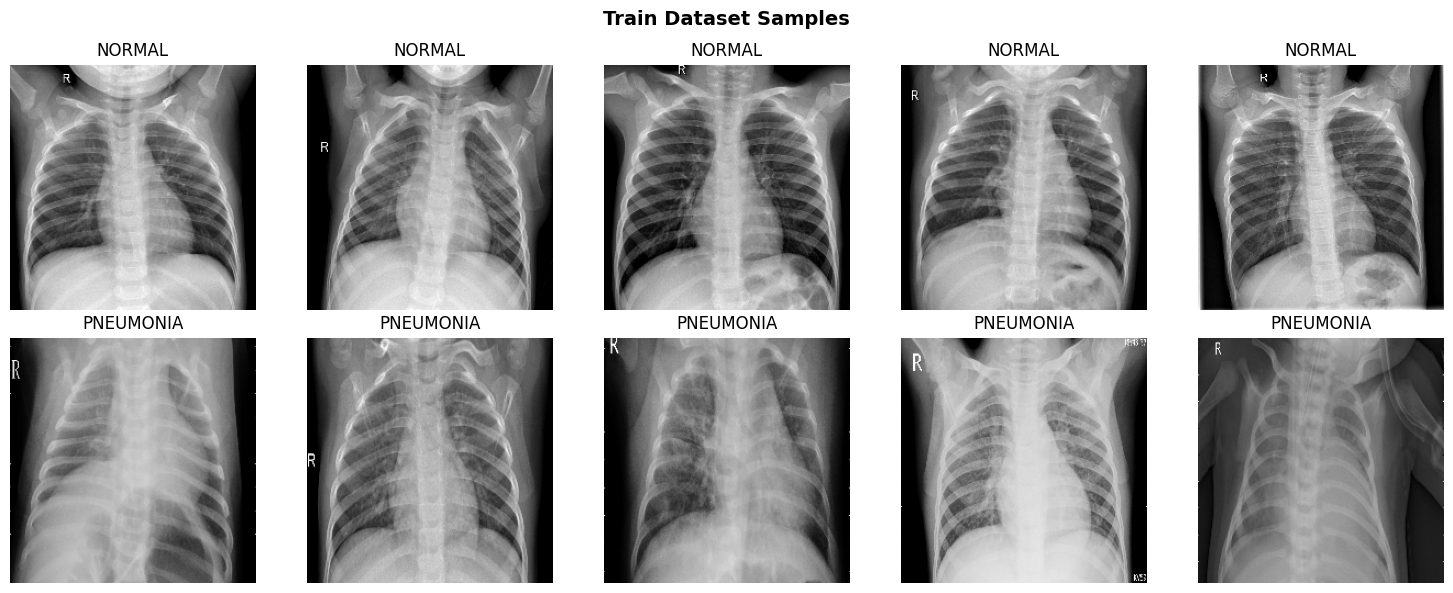

In [ ]:
visualize_samples(train_dataset, "Train Dataset Samples")

The images still contain clear X-ray details.

## Split into input X and output y

In [ ]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, lbl in dataset.unbatch().as_numpy_iterator():
        images.append(img)
        labels.append(lbl)
    return np.array(images), np.array(labels)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)
X_val_original, y_val_original = dataset_to_numpy(val_dataset)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    stratify=y_train,
    random_state=42
)

# --- Balance validation set ---
# Get indices for each class
normal_idx = np.where(y_val == 0)[0]
pneu_idx   = np.where(y_val == 1)[0]

# Find minority count
min_count = min(len(normal_idx), len(pneu_idx))

# Randomly sample equal numbers
np.random.seed(42)
normal_sample = np.random.choice(normal_idx, min_count, replace=False)
pneu_sample   = np.random.choice(pneu_idx, min_count, replace=False)

# Combine balanced indices
balanced_idx = np.concatenate([normal_sample, pneu_sample])

# Create balanced validation set
X_val = X_val[balanced_idx]
y_val = y_val[balanced_idx]


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nValidation class distribution:")
print(f"Normal: {np.sum(y_val == 0)}")
print(f"Pneumonia: {np.sum(y_val == 1)}")

print(f"Train class distribution:")
print(f"Normal: {np.sum(y_train == 0)}")
print(f"Pneumonia: {np.sum(y_train == 1)}")

print(f"Test class distribution:")
print(f"Normal: {np.sum(y_test == 0)}")
print(f"Pneumonia: {np.sum(y_test == 1)}")

X_train shape: (4433, 224, 224, 1)
y_train shape: (4433,)
X_val shape: (402, 224, 224, 1)
y_val shape: (402,)
X_test shape: (624, 224, 224, 1)
y_test shape: (624,)

Validation class distribution:
Normal: 201
Pneumonia: 201
Train class distribution:
Normal: 1140
Pneumonia: 3293
Test class distribution:
Normal: 234
Pneumonia: 390


## Data Augmentation



> - "Using geometric and other transformations can help you train robust and accurate machine-learning models."
> - "For example, in the case of Pneumonia Classification, you can use random cropping, zooming, stretching, and color space transformation to improve the model performance. However, you need to be careful about certain augmentations as they can result in opposite results. For example, random rotation and reflection along the x-axis are not recommended for the X-ray imaging dataset."
DataCamp. (n.d.). A complete guide to data augmentation.
- Reference: DataCamp. https://www.datacamp.com/tutorial/complete-guide-data-augmentation







In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest'
)

augmented_data = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

# **Part 3: Building the model**

## Basic CNN model

Architecture Design:
(Conv2D → BatchNorm → MaxPool2D) × 4 → Flatten → Dense → Output

In [ ]:
from keras import layers, models

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    # Block 4
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    # Flatten and Dense
    layers.GlobalAveragePooling2D(), #This instead of flatten
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model summary

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,785 (1.61 MB)

 Trainable params: 421,825 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

## Compile and train the model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#EarlyStopping automatically prevents overfitting by stopping training when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    augmented_data,
    epochs=50,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 32, #divides all training images into batches of 32, and after processing all these batches, that counts as 1 epoch
    callbacks=[early_stop],
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - accuracy: 0.7971 - loss: 0.4202 - val_accuracy: 0.5000 - val_loss: 4.7390
Epoch 2/50
  1/138 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8750 - loss: 0.2032

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.2032 - val_accuracy: 0.5000 - val_loss: 4.4445
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.8925 - loss: 0.2630 - val_accuracy: 0.5000 - val_loss: 6.8786
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.3527 - val_accuracy: 0.5000 - val_loss: 6.9654
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.8971 - loss: 0.2509 - val_accuracy: 0.5000 - val_loss: 8.8605
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.3684 - val_accuracy: 0.5000 - val_loss: 8.0409
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9184 - loss: 0.2105 - val_accuracy: 0.5423 - val_loss: 1.6901
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.5152 - val_accuracy: 0.5075 - val_loss: 2.1686
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9147 - loss: 0.2143 - val_accuracy: 0

# **Model Evaluation Functions**

## Accuracy, loss, Precision, recall and f1 score of test

In [ ]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'\nTest Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-Score: {f1:.4f}')

    return y_pred, test_loss, test_acc, precision, recall, f1

## Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_test, y_pred, color='Blues'):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f'Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"\nTrue Negatives: {cm[0][0]}")
    print(f"False Positives: {cm[0][1]}")
    print(f"False Negatives: {cm[1][0]}")
    print(f"True Positives: {cm[1][1]}")

    return cm

## Plot Training History (Visualize training vs validation performance (loss & accuracy curves))

In [ ]:
def plot_training_history(history, color='green'):
    best_epoch = np.argmin(history.history['val_loss'])
    print(f"\n=== Training History ===")
    print(f"Model restored to epoch: {best_epoch + 1}")
    print(f"Val_loss at that epoch: {history.history['val_loss'][best_epoch]:.4f}")
    print(f"Val_accuracy at that epoch: {history.history['val_accuracy'][best_epoch]:.4f}")

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color=color)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color=f'light{color}')
    plt.axvline(x=best_epoch, color=f'dark{color}', linestyle='--', linewidth=2.5,
                label=f'Restored to Epoch {best_epoch+1}')
    plt.title(f'Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color=color)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2, color=f'light{color}')
    plt.axvline(x=best_epoch, color=f'dark{color}', linestyle='--', linewidth=2.5,
                label=f'Restored to Epoch {best_epoch+1}')
    plt.title(f'Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# **Part 4: Evaluation**

## Accuracy, Precision, Recall, F1 Score

In [ ]:
y_pred_original, test_loss_original, test_acc_original, precision_original, recall_original, f1_original = evaluate_model(model, X_test, y_test)

20/20 - 1s - 69ms/step - accuracy: 0.8638 - loss: 0.6472
Test Loss: 0.6472
Test Accuracy: 0.8638
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step

Test Precision: 0.8252
Test Recall: 0.9923
Test F1-Score: 0.9010


## Confusion Matrix

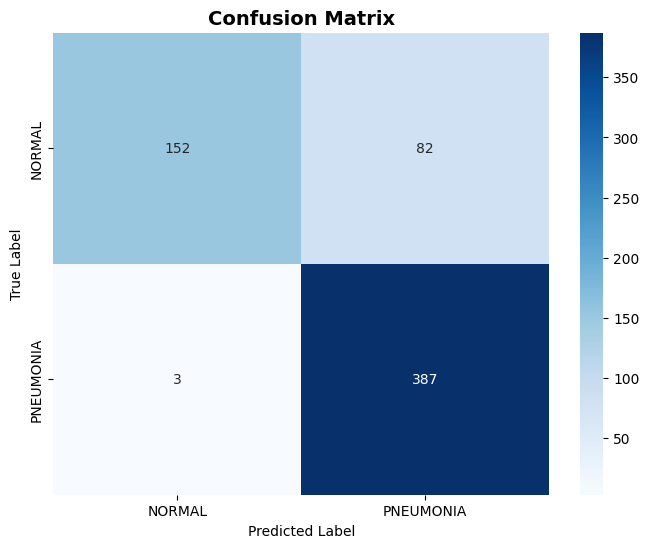


True Negatives: 152
False Positives: 82
False Negatives: 3
True Positives: 387


array([[152,  82],
       [  3, 387]])

In [ ]:
plot_confusion_matrix(y_test, y_pred_original, color='Blues')

## Visualize training vs validation performance (loss & accuracy curves)


=== Training History ===
Model restored to epoch: 23
Val_loss at that epoch: 0.1120
Val_accuracy at that epoch: 0.9552


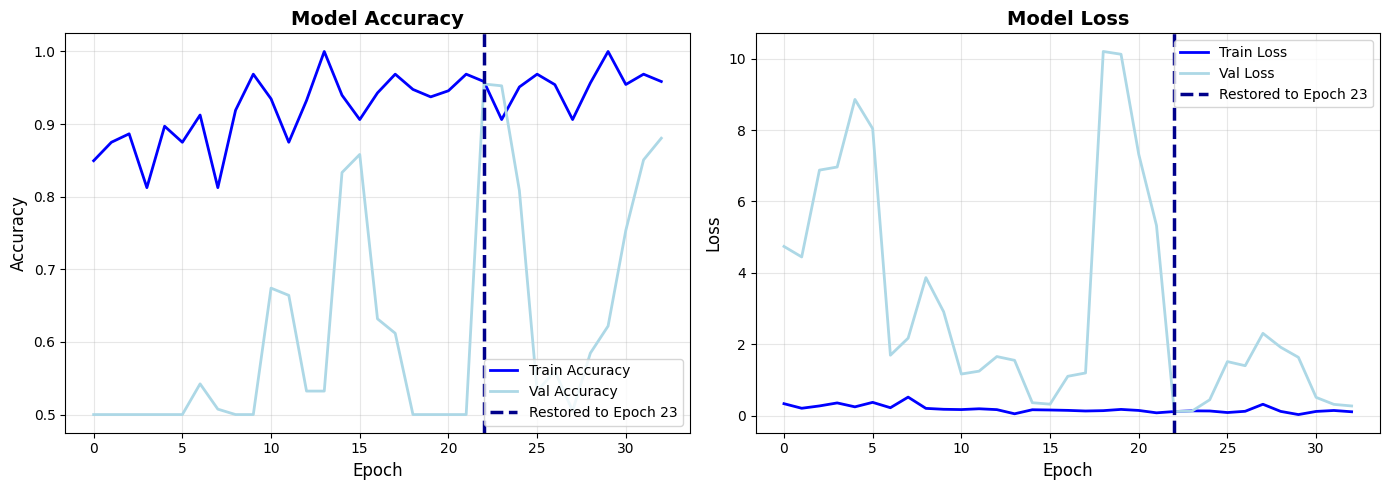

In [ ]:
plot_training_history(history, color='blue')

# **Part 5: Transfer Learning Model**

## Change the images to rgb + data augmentation

In [ ]:
# Convert existing grayscale data (224, 224, 1) to RGB (224, 224, 3)
# by repeating the single channel 3 times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Labels stay the same: y_train, y_val, y_test

print(f"\nOriginal grayscale shape: {X_train.shape}")
#Verify conversion

print(f"X_train_rgb shape: {X_train_rgb.shape}")
print(f"X_val_rgb shape: {X_val_rgb.shape}")
print(f"X_test_rgb shape: {X_test_rgb.shape}")

# Data augmentation for RGB
datagen_rgb = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest'
)

data_aug_rgb = datagen_rgb.flow(X_train_rgb, y_train, batch_size=32, shuffle=True)


Original grayscale shape: (4433, 224, 224, 1)
X_train_rgb shape: (4433, 224, 224, 3)
X_val_rgb shape: (402, 224, 224, 3)
X_test_rgb shape: (624, 224, 224, 3)


## Load the pre-trained model (DenseNet121 ) + Build the model

In [ ]:
#Reminder IMG_SIZE = 224
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

#freeze all layers
base_model.trainable = False


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers in DenseNet121: 427
Trainable layers: 0


In [ ]:
densenet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    #Dense layer
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Model summary
densenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,281 (27.87 MB)

 Trainable params: 265,217 (1.01 MB)

 Non-trainable params: 7,040,064 (26.86 MB)

## Compile and train

In [ ]:
# Compile the model
densenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stop_densenet = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

#Train the model
history_densenet = densenet_model.fit(
    data_aug_rgb,
    epochs=50,
    validation_data=(X_val_rgb, y_val),
    steps_per_epoch= len(X_train_rgb)//32,
    callbacks=[early_stop_densenet]

)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 121s 658ms/step - accuracy: 0.8127 - loss: 0.4703 - val_accuracy: 0.9378 - val_loss: 0.1940
Epoch 2/50
  1/138 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.9688 - loss: 0.1190

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9688 - loss: 0.1190 - val_accuracy: 0.9353 - val_loss: 0.1914
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 50s 363ms/step - accuracy: 0.9193 - loss: 0.2254 - val_accuracy: 0.9378 - val_loss: 0.1910
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9375 - loss: 0.1752 - val_accuracy: 0.9378 - val_loss: 0.1905
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 371ms/step - accuracy: 0.9306 - loss: 0.1851 - val_accuracy: 0.9353 - val_loss: 0.1944
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0757 - val_accuracy: 0.9353 - val_loss: 0.1941
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 374ms/step - accuracy: 0.9334 - loss: 0.1744 - val_accuracy: 0.9428 - val_loss: 0.1864
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1913 - val_accuracy: 0.9428 - val_loss: 0.1871
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 373ms/step - accuracy: 0.9412 - loss: 0.1492 - val_accuracy: 

## Evaluate the model (densenet_model)

20/20 - 13s - 671ms/step - accuracy: 0.9183 - loss: 0.2267
Test Loss: 0.2267
Test Accuracy: 0.9183
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 723ms/step

Test Precision: 0.9124
Test Recall: 0.9615
Test F1-Score: 0.9363


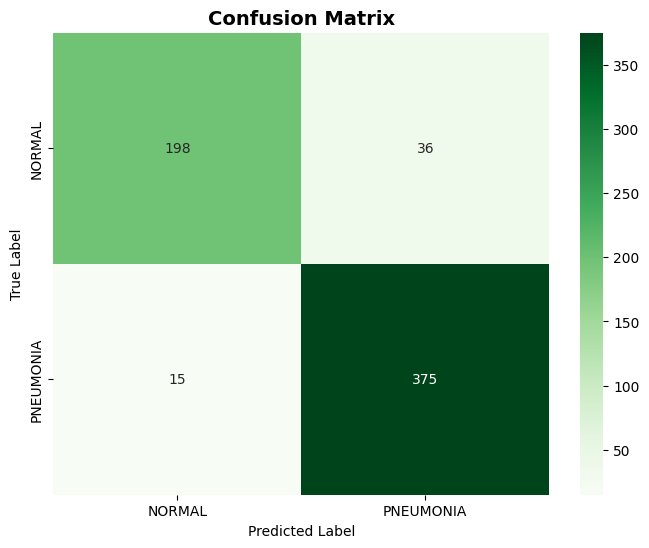


True Negatives: 198
False Positives: 36
False Negatives: 15
True Positives: 375

=== Training History ===
Model restored to epoch: 9
Val_loss at that epoch: 0.1719
Val_accuracy at that epoch: 0.9378


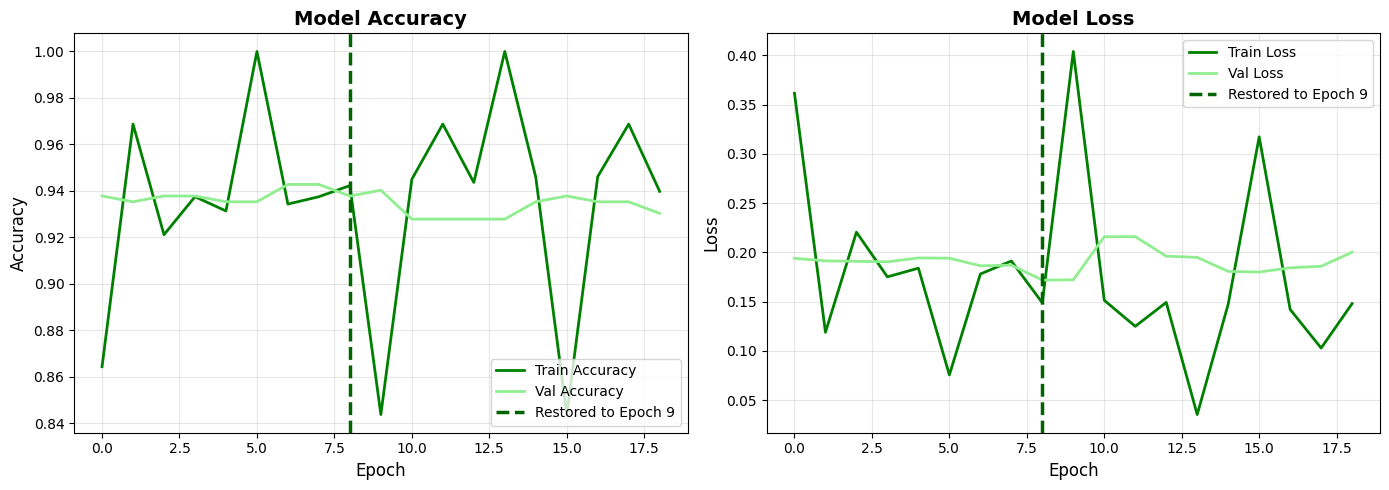

In [ ]:
print("Accuracy, loss, accuracy, precision, recall, f1-score of test set:")
y_pred_densenet, test_loss_densenet, test_acc_densenet, precision_densenet, recall_densenet, f1_densenet = evaluate_model(densenet_model, X_test_rgb, y_test)
print("Confusion Matrix: ")
plot_confusion_matrix(y_test, y_pred_densenet, color='Greens')
print("Visualize training vs validation performance (loss & accuracy curves)")
plot_training_history(history_densenet, color='green')